In [ ]:
from google.colab import auth
auth.authenticate_user()

# Make Directory
!mkdir PAN

# Mount GCS bucket
!gcloud config set project dsgt-clef-2024
#!pip install gcsfuse
!gsutil ls


!gsutil -m cp -r gs://dsgt-clef-pan-2024/* /content/PAN/

#check
!ls PAN

Updated property [core/project].
gs://dsgt-clef-2024/
gs://dsgt-clef-2024-spark-history/
gs://dsgt-clef-2024-tfstate/
gs://dsgt-clef-bioasq-2024/
gs://dsgt-clef-birdclef-2024/
gs://dsgt-clef-erisk-2024/
gs://dsgt-clef-fungiclef-2024/
gs://dsgt-clef-geolifeclef-2024/
gs://dsgt-clef-idpp-2024/
gs://dsgt-clef-longeval-2024/
gs://dsgt-clef-pan-2024/
gs://dsgt-clef-plantclef-2024/
gs://dsgt-clef-snakeclef-2024/
gs://dsgt-clef-touche-2024/
Copying gs://dsgt-clef-pan-2024/10_Iterations_first_5000_no_wikipedia_Ben_GCN_model.pth...
Copying gs://dsgt-clef-pan-2024/10_Iterations_first_5000_wikipedia_False_Ben_GCN_model.pth...
Copying gs://dsgt-clef-pan-2024/50_Iterations_first_5000_wikipedia_True_Convs_10Ben_GCN_model.pth...
Copying gs://dsgt-clef-pan-2024/550_Iterations_first_5000_wikipedia_False_Ben_GCN_model.pth...
Copying gs://dsgt-clef-pan-2024/Ben_Data/CLS_tokens.json...
Copying gs://dsgt-clef-pan-2024/Ben_Data/No_Wiki2Vec/5000/CLS_tokens.json...
Copying gs://dsgt-clef-pan-2024/Ben_Data/No_

Data Pipeline

In [ ]:
import pandas as pd
GPT = pd.read_csv('/content/PAN/PAN Data/GPT-wiki-intro.csv')
Nabeel = pd.read_csv('/content/PAN/PAN Data/HF_NabeelShar_ai_and_human_text.csv')

!pip install fastparquet
!pip install tdqm
import fastparquet
df = pd.read_parquet('/content/PAN/PAN Data/HF_artem9k_ai_text_detection_pile/train-00000-of-00007-bc5952582e004d67.parquet', engine='fastparquet')

import os
files = os.listdir('/content/PAN/PAN Data/HF_artem9k_ai_text_detection_pile/')
dtf = pd.DataFrame()
for file in files:
  df = pd.read_parquet('/content/PAN/PAN Data/HF_artem9k_ai_text_detection_pile/' + file, engine='fastparquet')
  dtf = pd.concat([dtf, df],axis = 0)
  print(file)


dtf['Type'] = 'HF_artem9k'
GPTcondensed = pd.DataFrame()

GPTcondensed['text'] = GPT['generated_intro'] + GPT['generated_text']
GPTcondensed['source'] = 'ai'

Humancondesned = pd.DataFrame()

Humancondesned['text'] = GPT['wiki_intro']
Humancondesned['source'] = 'human'
GPTcondensed = pd.concat([GPTcondensed, Humancondesned], axis = 0)
GPTcondensed['Type'] = 'GPT'



Nabeel['source'] = Nabeel['generated'].map({0:'human', 1:'ai'})
Nabeel['Type'] = 'HF Nabeel'

dfz = pd.read_csv('/content/PAN/PAN Data/HF_dmitva_human_ai_generated_text.csv')

import numpy as np
dfz = pd.DataFrame(pd.concat([dfz['human_text'],dfz['ai_text']],axis = 0),columns = ['text'])
dfz['source'] = np.hstack((['human']*500000,['ai']*500000))

dfz['Type'] = 'HF_dmitva'

Final = pd.concat([dfz[['source','text','Type']],
           Nabeel[['source','text','Type']],
           GPTcondensed[['source','text','Type']],
           dtf[['source','text','Type']]],axis = 0)

del dfz
del Nabeel
del GPTcondensed
del dtf
del df
del GPT
del Humancondesned

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1323 sha256=14c3b5b61f0735208da14c6cb7d9c16807ab0ba9ed93b627199976a9fa60c347
  Stored in directory: /root/.cache/pip/wheels/37/31/b8/7b711038035720ba0df14376af06e5e76b9bd61759c861ad92
Successfully built tdqm
train-00002-of-00007-ee2d43f396e78fbc.parquet
train-00003-of-00007-529931154b42b51d.parquet
train-00000-of-00007-bc5952582e004d67.parquet
train-00005-of-00007-3dce5e05ddbad789.parquet
train-00006-of-00007-3d8a471ba0cf1c8d.parquet
train-00001-of-00007-71c80017bc45f30d.parquet
train-00004-of-00007-b269dc49374a2c0b.parquet


In [ ]:

def count_words(text):
    words = text.split()
    return len(words)
Final['wordcount'] = Final['text'].apply(count_words)

Final = Final.loc[Final['wordcount'] <= 500].reset_index(drop = True)


Humantexts = Final.loc[Final['source'] == 'human'].sample(n=10000,random_state = 42).reset_index(drop = True)
Aitexts = Final.loc[Final['source'] == 'ai'].sample(n=10000,random_state = 42).reset_index(drop = True)
Combined = pd.concat([Humantexts,Aitexts],axis = 0,ignore_index=True)
Combined = Combined.sample(frac=1).reset_index(drop=True)

In [ ]:
!pip install spacy-transformers
!python3 -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.9/197.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 38.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyli

In [ ]:

import torch
!pip install torch_geometric
!python3 -m spacy download en_core_web_trf

import nltk
!pip install svgling
nltk.download('punkt')  # Download the Punkt tokenizer models
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk import sent_tokenize
from nltk import word_tokenize, pos_tag, ne_chunk

import spacy

#import spacy_transformers

# Load the English NER model
nlp = spacy.load("en_core_web_trf")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_trf-3.7.3/en_core_web_trf-3.7.3-py3-none-any.whl (457.4 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_no

In [ ]:
!pip install wikipedia2vec
!wget http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.pkl.bz2

import os
import bz2

# Path to the compressed file
compressed_file_path = '/content/enwiki_20180420_100d.pkl.bz2'

# Path to save the extracted model file
extracted_file_path = '/content/enwiki_20180420_100d.pkl'

# Extract the model file
with open(extracted_file_path, 'wb') as new_file, bz2.BZ2File(compressed_file_path, 'rb') as file:
    for data in iter(lambda : file.read(100 * 1024), b''):
        new_file.write(data)

from wikipedia2vec import Wikipedia2Vec
wiki2vec = Wikipedia2Vec.load(extracted_file_path)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 28.3 MB/s eta 0:00:00
--2024-04-16 01:26:47--  http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.pkl.bz2
Resolving wikipedia2vec.s3.amazonaws.com (wikipedia2vec.s3.amazonaws.com)... 52.219.1.89, 52.219.150.137, 52.219.8.73, ...
Connecting to wikipedia2vec.s3.amazonaws.com (wikipedia2vec.s3.amazonaws.com)|52.219.1.89|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3514838671 (3.3G) [application/x-bzip2]
Saving to: ‘enwiki_20180420_100d.pkl.bz2’

enwiki_20180420_100 100%[===================>]   3.27G  41.0MB/s    in 84s     

2024-04-16 01:28:11 (40.1 MB/s) - ‘enwiki_20180420_100d.pkl.bz2’ saved [3514838671/3514838671]



/usr/local/lib/python3.10/dist-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[-0.12560804 -0.5235532  -0.13231167 ... -0.48633438  0.45111445
   0.11309847]
 [-0.12473089 -0.6455471   0.13622157 ... -0.6347396   0.5410465
   0.32159257]
 [-0.05129661 -0.4987064  -0.09563554 ... -0.30148467  0.24280211
  -0.08308805]
 ...
 [-1.0583687  -0.83086014 -0.4427682  ... -1.0160557  -0.02469787
   0.99688977]
 [-1.0772408  -0.32139003 -0.79673034 ... -1.3150353  -0.12155519
   0.57841384]
 [-0.86319923 -0.5425662  -0.5506818  ... -1.1069874   0.26995388
   0.43403685]] loaded from the file /content/enwiki_20180420_100d.pkl is not byte aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/joblib/numpy_pick

In [ ]:
from transformers import BertTokenizer, BertForNextSentencePrediction
from transformers import RobertaTokenizer, RobertaModel

import torch
import spacy
from nltk.tokenize import sent_tokenize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BERT model and tokenizer outside of functions
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased').to(device)

# Load pre-trained RoBERTa tokenizer and model
Roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-large")
Roberta_model = RobertaModel.from_pretrained("roberta-large").to(device)


def calculate_nsp_score(sentence1, sentence2, model=model, tokenizer=tokenizer):
    inputs = tokenizer(sentence1, sentence2, return_tensors='pt', max_length=512, truncation=True, padding='max_length').to(device)
    with torch.no_grad():
      outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    nsp_score = probabilities[0][0].item()
    return nsp_score

def get_roberta_embedding(sentences, model=Roberta_model, tokenizer=Roberta_tokenizer):
    # Tokenize sentences into individual words
    tokens = tokenizer.tokenize(sentences)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids_tensor = torch.tensor([input_ids]).to(device)

    # Get the Roberta model output for the input tensor
    with torch.no_grad():
        output = model(input_ids_tensor).last_hidden_state[:, 0, :]

    return output
#try detaching  tensor, happens when you
def get_ner_embeddings(sentences, nlp=nlp):
    doc = nlp(sentences)
    ner_embeddings = []
    for ent in doc.ents:
        ent_embedding = get_roberta_embedding(ent.text)
        ner_embeddings.append((ent, ent_embedding))
    return ner_embeddings

def doc_ner_embeddings(document):
    sentences = sent_tokenize(document)
    doc_ents = {}
    prev_sent = ""
    nsp_scores = []
    for i, sentence in enumerate(sentences):
        ner_embeddings = get_ner_embeddings(sentence)
        doc_ents[i] = ner_embeddings
        if i > 0:
            nsp_score = calculate_nsp_score(prev_sent, sentence)
            nsp_scores.append(nsp_score)
        prev_sent = sentence
    return doc_ents, nsp_scores

def wiki2vecs(entity):
    try:
        wiki = torch.tensor(wiki2vec.get_entity_vector(entity))
    except:
        try:
            wiki = torch.tensor(wiki2vec.get_word_vector(entity))
        except:
            wiki = torch.zeros(100)
    return wiki

def CLS_token(document, model=Roberta_model, tokenizer=Roberta_tokenizer):
    input_ids = tokenizer.encode(document, add_special_tokens=True, return_tensors='pt',max_length=512,truncation=True).to(device)
    with torch.no_grad():
        outputs = model(input_ids)
    hidden_states = outputs.last_hidden_state
    cls_representation = hidden_states[:, 0, :]
    return cls_representation


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

texts = {}
Targets = {}
CLS_tokens = {}
dataset_size = 20000

document_list = Combined['text'][:dataset_size]

def process_document(texts,Targets,CLS_tokens,document_list):
  for i, text in enumerate(document_list):
    temp = doc_ner_embeddings(text)
    check = sum(len(temp[0][key]) for key in temp[0].keys())
    if check < 3:
        print(f"Document {i} skipped")
        continue

    targets = 0 if Combined['source'][i] == 'ai' else 1
    cls_token = CLS_token(text)
    texts[i], Targets[i], CLS_tokens[i] = temp, targets, cls_token
    print(i)
  return texts,Targets,CLS_tokens

texts,Targets,CLS_tokens = process_document(texts,Targets,CLS_tokens,document_list)

0
Document 1 skipped
2
Document 3 skipped
Document 4 skipped
5
6
Document 7 skipped
Document 8 skipped
Document 9 skipped
Document 10 skipped
Document 11 skipped
12
13
Document 14 skipped
15
16
17
18
Document 19 skipped
20
Document 21 skipped
Document 22 skipped
23
24
25
26
Document 27 skipped
Document 28 skipped
Document 29 skipped
Document 30 skipped
Document 31 skipped
32
Document 33 skipped
34
Document 35 skipped
Document 36 skipped
Document 37 skipped
38
Document 39 skipped
40
41
Document 42 skipped
43
44
45
46
Document 47 skipped
Document 48 skipped
Document 49 skipped
50
51
52
53
54
Document 55 skipped
Document 56 skipped
57
58
59
60
61
62
63
64
Document 65 skipped
Document 66 skipped
Document 67 skipped
68
Document 69 skipped
70
71
72
Document 73 skipped
74
75
76
77
Document 78 skipped
Document 79 skipped
Document 80 skipped
Document 81 skipped
82
83
Document 84 skipped
Document 85 skipped
86
87
88
89
90
91
92
Document 93 skipped
94
95
Document 96 skipped
97
98
99
100
101
102
1

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


900
901
902
903
Document 904 skipped
905
906
Document 907 skipped
908
909
Document 910 skipped
Document 911 skipped
912
913
914
915
916
917
918
919
920
Document 921 skipped
Document 922 skipped
Document 923 skipped
Document 924 skipped
925
926
927
928
Document 929 skipped
Document 930 skipped
931
932
933
Document 934 skipped
935
936
937
938
Document 939 skipped
940
941
942
Document 943 skipped
Document 944 skipped
Document 945 skipped
946
947
948
949
Document 950 skipped
951
952
953
954
955
956
957
958
959
960
Document 961 skipped
962
963
964
965
966
967
968
969
970
971
Document 972 skipped
Document 973 skipped
974
975
976
Document 977 skipped
978
979
980
981
982
983
Document 984 skipped
985
986
987
Document 988 skipped
Document 989 skipped
Document 990 skipped
991
992
993
Document 994 skipped
995
996
997
Document 998 skipped
999
Document 1000 skipped
1001
1002
1003
1004
1005
1006
1007
Document 1008 skipped
1009
Document 1010 skipped
1011
1012
Document 1013 skipped
1014
Document 1015 s

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1623
1624
1625
1626
Document 1627 skipped
1628
1629
1630
Document 1631 skipped
Document 1632 skipped
Document 1633 skipped
1634
Document 1635 skipped
Document 1636 skipped
Document 1637 skipped
1638
Document 1639 skipped
Document 1640 skipped
Document 1641 skipped
1642
1643
1644
1645
1646
Document 1647 skipped
1648
Document 1649 skipped
1650
Document 1651 skipped
Document 1652 skipped
1653
1654
1655
1656
Document 1657 skipped
1658
Document 1659 skipped
Document 1660 skipped
1661
1662
1663
Document 1664 skipped
1665
Document 1666 skipped
1667
1668
1669
1670
Document 1671 skipped
Document 1672 skipped
Document 1673 skipped
Document 1674 skipped
1675
Document 1676 skipped
1677
Document 1678 skipped
Document 1679 skipped
Document 1680 skipped
Document 1681 skipped
Document 1682 skipped
1683
1684
1685
Document 1686 skipped
1687
Document 1688 skipped
1689
Document 1690 skipped
Document 1691 skipped
1692
1693
1694
1695
Document 1696 skipped
1697
1698
1699
Document 1700 skipped
1701
1702
1703


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2981
Document 2982 skipped
2983
Document 2984 skipped
Document 2985 skipped
2986
2987
2988
2989
2990
2991
2992
2993
Document 2994 skipped
Document 2995 skipped
Document 2996 skipped
2997
Document 2998 skipped
2999
3000
3001
Document 3002 skipped
Document 3003 skipped
Document 3004 skipped
3005
Document 3006 skipped
3007
3008
3009
3010
Document 3011 skipped
3012
Document 3013 skipped
Document 3014 skipped
3015
3016
Document 3017 skipped
3018
Document 3019 skipped
Document 3020 skipped
3021
3022
Document 3023 skipped
3024
3025
Document 3026 skipped
3027
Document 3028 skipped
3029
Document 3030 skipped
Document 3031 skipped
3032
3033
Document 3034 skipped
3035
3036
3037
3038
Document 3039 skipped
3040
3041
3042
3043
3044
3045
3046
Document 3047 skipped
3048
3049
3050
Document 3051 skipped
3052
3053
3054
3055
3056
Document 3057 skipped
3058
3059
3060
3061
3062
3063
3064
Document 3065 skipped
Document 3066 skipped
3067
3068
Document 3069 skipped
3070
Document 3071 skipped
3072
3073
Document

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4050
4051
4052
4053
4054
4055
Document 4056 skipped
4057
4058
4059
Document 4060 skipped
4061
Document 4062 skipped
Document 4063 skipped
4064
Document 4065 skipped
4066
Document 4067 skipped
Document 4068 skipped
4069
4070
4071
4072
4073
4074
Document 4075 skipped
4076
4077
Document 4078 skipped
Document 4079 skipped
4080
4081
Document 4082 skipped
Document 4083 skipped
4084
Document 4085 skipped
4086
Document 4087 skipped
4088
4089
4090
Document 4091 skipped
4092
4093
Document 4094 skipped
4095
Document 4096 skipped
4097
4098
4099
4100
4101
4102
Document 4103 skipped
4104
4105
Document 4106 skipped
Document 4107 skipped
4108
4109
4110
4111
4112
Document 4113 skipped
4114
4115
Document 4116 skipped
4117
4118
Document 4119 skipped
4120
4121
Document 4122 skipped
4123
4124
4125
Document 4126 skipped
Document 4127 skipped
Document 4128 skipped
4129
4130
Document 4131 skipped
4132
Document 4133 skipped
Document 4134 skipped
4135
Document 4136 skipped
4137
4138
4139
Document 4140 skipped
4

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
Document 5473 skipped
5474
5475
5476
5477
5478
5479
5480
5481
5482
Document 5483 skipped
5484
Document 5485 skipped
5486
5487
Document 5488 skipped
5489
5490
5491
5492
Document 5493 skipped
Document 5494 skipped
Document 5495 skipped
5496
Document 5497 skipped
5498
Document 5499 skipped
Document 5500 skipped
5501
Document 5502 skipped
Document 5503 skipped
Document 5504 skipped
Document 5505 skipped
Document 5506 skipped
5507
Document 5508 skipped
5509
Document 5510 skipped
5511
5512
5513
Document 5514 skipped
5515
Document 5516 skipped
Document 5517 skipped
5518
5519
5520
Document 5521 skipped
Document 5522 skipped
5523
5524
Document 5525 skipped
Document 5526 skipped
5527
Document 5528 skipped
5529
Document 5530 skipped
5531
Document 5532 skipped
5533
5534
5535
5536
5537
Document 5538 skipped
5539
Document 5540 skipped
5541
Document 5542 skipped
Document 5543 skipped
5544
5545
Document 5546 skipped
5547
5548
Document 5549 skipped

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


5714
Document 5715 skipped
Document 5716 skipped
5717
5718
Document 5719 skipped
Document 5720 skipped
5721
Document 5722 skipped
Document 5723 skipped
Document 5724 skipped
5725
Document 5726 skipped
5727
5728
Document 5729 skipped
Document 5730 skipped
Document 5731 skipped
Document 5732 skipped
Document 5733 skipped
5734
Document 5735 skipped
5736
5737
Document 5738 skipped
Document 5739 skipped
5740
5741
5742
5743
5744
Document 5745 skipped
5746
5747
Document 5748 skipped
5749
Document 5750 skipped
Document 5751 skipped
5752
5753
5754
5755
5756
Document 5757 skipped
5758
5759
5760
Document 5761 skipped
5762
5763
5764
Document 5765 skipped
Document 5766 skipped
5767
Document 5768 skipped
5769
5770
Document 5771 skipped
Document 5772 skipped
5773
Document 5774 skipped
5775
5776
Document 5777 skipped
5778
5779
5780
5781
5782
Document 5783 skipped
Document 5784 skipped
Document 5785 skipped
5786
Document 5787 skipped
Document 5788 skipped
5789
5790
Document 5791 skipped
5792
5793
5794


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10373
Document 10374 skipped
10375
Document 10376 skipped
10377
10378
10379
10380
Document 10381 skipped
Document 10382 skipped
Document 10383 skipped
10384
10385
Document 10386 skipped
10387
10388
10389
10390
10391
10392
Document 10393 skipped
Document 10394 skipped
10395
Document 10396 skipped
Document 10397 skipped
10398
10399
Document 10400 skipped
Document 10401 skipped
Document 10402 skipped
Document 10403 skipped
10404
10405
Document 10406 skipped
Document 10407 skipped
10408
Document 10409 skipped
10410
10411
10412
10413
10414
Document 10415 skipped
10416
10417
Document 10418 skipped
10419
Document 10420 skipped
Document 10421 skipped
10422
10423
Document 10424 skipped
10425
Document 10426 skipped
10427
10428
10429
10430
Document 10431 skipped
10432
Document 10433 skipped
Document 10434 skipped
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
Document 10445 skipped
10446
Document 10447 skipped
10448
10449
Document 10450 skipped
Document 10451 skipped
Document 10452 s

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10761
10762
Document 10763 skipped
10764
Document 10765 skipped
Document 10766 skipped
10767
10768
10769
Document 10770 skipped
10771
Document 10772 skipped
10773
10774
10775
Document 10776 skipped
10777
Document 10778 skipped
10779
Document 10780 skipped
Document 10781 skipped
Document 10782 skipped
10783
10784
Document 10785 skipped
10786
10787
10788
10789
10790
10791
Document 10792 skipped
10793
10794
Document 10795 skipped
10796
Document 10797 skipped
10798
10799
Document 10800 skipped
10801
10802
10803
Document 10804 skipped
Document 10805 skipped
10806
10807
Document 10808 skipped
10809
10810
10811
10812
10813
10814
Document 10815 skipped
10816
10817
10818
Document 10819 skipped
Document 10820 skipped
10821
10822
Document 10823 skipped
Document 10824 skipped
10825
10826
Document 10827 skipped
10828
10829
10830
10831
10832
Document 10833 skipped
Document 10834 skipped
Document 10835 skipped
10836
Document 10837 skipped
Document 10838 skipped
10839
10840
10841
Document 10842 skippe

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11777
Document 11778 skipped
Document 11779 skipped
11780
11781
Document 11782 skipped
Document 11783 skipped


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11784
11785
Document 11786 skipped
Document 11787 skipped
Document 11788 skipped
Document 11789 skipped
11790
11791
11792
11793
Document 11794 skipped
11795
11796
Document 11797 skipped
11798
11799
11800
Document 11801 skipped
11802
Document 11803 skipped
Document 11804 skipped
11805
11806
Document 11807 skipped
11808
11809
Document 11810 skipped
Document 11811 skipped
Document 11812 skipped
11813
Document 11814 skipped
Document 11815 skipped
11816
11817
11818
11819
Document 11820 skipped
11821
11822
11823
Document 11824 skipped
11825
Document 11826 skipped
Document 11827 skipped
Document 11828 skipped
11829
11830
11831
11832
Document 11833 skipped
11834
11835
11836
Document 11837 skipped
11838
11839
Document 11840 skipped
11841
Document 11842 skipped
Document 11843 skipped
11844
11845
11846
Document 11847 skipped
11848
11849
11850
Document 11851 skipped
Document 11852 skipped
11853
11854
Document 11855 skipped
11856
11857
11858
Document 11859 skipped
Document 11860 skipped
11861
11862

OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 21130 has 14.74 GiB memory in use. Of the allocated memory 14.56 GiB is allocated by PyTorch, and 56.00 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

def cosine_sim(vec1, vec2):

  cosine_similarity = F.cosine_similarity(vec1, vec2, dim=1)
  return cosine_similarity

def flat_vec(vec):
  # Flatten the vectors along the specified axis
  return vec

def adjacency_matrix_to_edge_index(adjacency_matrix):
    num_nodes = adjacency_matrix.shape[0]
    edge_index = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adjacency_matrix[i][j] != 0:
                edge_index.append([i, j])
    edge_index = torch.tensor(edge_index).t().contiguous()
    return edge_index


def Return_inputs(combo,similarity = 0.9,wiki2vec = False):
  texts = combo[0]
  nsp_scores = combo[1]
  ##Parse Node Pairs
  Node_Pairs = {}
  for i in range(len(texts)):
    for j in range(len(texts)):
      if i == j: #inner Sentence Pairs

        for k in range(len(texts[i])-1):
          for l in range(k+1,len(texts[j])):
            if k!=l:
              pair_1 = str(texts[i][k][0])
              pair_2 = str(texts[j][l][0])
              pair_1Robeta = flat_vec(texts[i][k][1])
              pair_2Robeta = flat_vec(texts[j][l][1])
              if wiki2vec:
                pair_1wiki = wiki2vecs(str(pair_1)).to(device)
                pair_2wiki = wiki2vecs(str(pair_2)).to(device)
                Node_Pairs[(pair_1,pair_2)] = (torch.concat((pair_1Robeta,pair_1wiki.unsqueeze(0)),dim = 1)
                ,torch.concat((pair_2Robeta,pair_2wiki.unsqueeze(0)),dim = 1))
              else:
                Node_Pairs[(pair_1,pair_2)] = (pair_1Robeta,pair_2Robeta)

      if i != j: #inter Sentence Pairs
        for k in range(len(texts[i])):
          for l in range(len(texts[j])):

            pair_1 = str(texts[i][k][0])
            pair_2 = str(texts[j][l][0])
            pair_1Robeta = flat_vec(texts[i][k][1])
            pair_2Robeta = flat_vec(texts[j][l][1])
            #check if similarity between inter sentence pairs is close enough
            sim = cosine_sim(texts[i][k][1],texts[j][l][1])
            if torch.Tensor.cpu(sim).numpy().sum()/sim.size()[0] > similarity:
              if wiki2vec:
                pair_1wiki = wiki2vecs(str(pair_1)).to(device)
                pair_2wiki = wiki2vecs(str(pair_2)).to(device)
                Node_Pairs[(pair_1,pair_2)] = (torch.concat((pair_1Robeta,pair_1wiki.unsqueeze(0)),dim = 1)
                ,torch.concat((pair_2Robeta,pair_2wiki.unsqueeze(0)),dim = 1))
              else:
                Node_Pairs[(pair_1,pair_2)] = (pair_1Robeta,pair_2Robeta)


  ##Remove duplicated reversed pairs
  unique_data = {}
  for key, value in Node_Pairs.items():
    sorted_key = tuple(sorted(key))
    unique_data[sorted_key] = value

  ##create a dictionary for each singular entity
  new_dict = {}

  for embeddings, values in unique_data.items():
      for embed, val in zip(embeddings, values):
          if embed not in new_dict:
              new_dict[embed] = []
          new_dict[embed].append(val)


  ##Have to average contextual representations
  averaged_dict = {}

  for embed, values in new_dict.items():
      # Stack the tensors along a new dimension (dim=0) and calculate the mean along that dimension
      averaged_tensor = torch.stack(values, dim=0).mean(dim=0)
      averaged_dict[embed] = averaged_tensor

  ##Adjaceny Matrix
  # Extract unique entities
  edges_values = unique_data
  entities = set(entity for edge in edges_values.keys() for entity in edge)

  # Create a mapping from entities to indices
  entity_to_index = {entity: idx for idx, entity in enumerate(entities)}

  # Initialize an adjacency matrix with zeros
  num_entities = len(entities)
  adjacency_matrix = np.zeros((num_entities, num_entities))

  # Fill in the adjacency matrix based on the values in your dictionary
  for (entity1, entity2), (val1, val2) in edges_values.items():
      idx1, idx2 = entity_to_index[entity1], entity_to_index[entity2]
      # You can choose how to combine val1 and val2, for example, summing them
      adjacency_matrix[idx1, idx2] += 1
      adjacency_matrix[idx2, idx1] += 1

  ##Degree Matrix
  # Calculate the degree for each node
  degrees = np.sum(adjacency_matrix, axis=1)

  # Create a degree matrix
  degree_matrix = np.diag(degrees)

  #Inverse and set np.inf to 0's
  inversed_d = degree_matrix**(-1/2)
  inversed_d[np.isinf(inversed_d)] = 0

  ##Create Matrix of word embeddings
  H_e = np.zeros((len(averaged_dict),averaged_dict[list(averaged_dict.keys())[0]].shape[1]))
  for i in range(len(averaged_dict)):
    H_e[i] = torch.Tensor.cpu(averaged_dict[list(averaged_dict.keys())[i]])


  A_squiggle = inversed_d@adjacency_matrix@inversed_d


  ##Create padded sequence of entities by sentence
  doocs = []
  lengths = []
  for keys in texts.keys():
    sents = []
    length = 0
    for pair in texts[keys]:
      sents.append(entity_to_index[str(pair[0])])
      length += 1
    lengths.append(length)
    doocs.append(sents)
  #pad_sequence(doocs,batch_first=True)

  return A_squiggle,H_e,doocs,entity_to_index,lengths,adjacency_matrix_to_edge_index(adjacency_matrix),nsp_scores

In [ ]:
def contains_nested_list(lst):
    for item in lst:
        if isinstance(item, list):
            return True
    return False


def Dataset_Curation(texts,similarity = 0.9,wiki2vec = False):
  Initial_embeddings = {}
  entity_sentence = {}
  length = {}
  nsp_score = {}
  adj_matrixs = {}

  for key in list(texts.keys()):
    try:
      A_squiggle,H_e,entity_sentences,ei_index,lengths,adj_matrix,nsp_scores = Return_inputs(texts[key],similarity = similarity,wiki2vec = wiki2vec)
      if contains_nested_list(nsp_scores):
        print(key,'continued')
        continue
      if len(nsp_scores) == 0:
        print(key,'continued')
        nsp_scores = nsp_scores[0]
        continue

      Initial_embeddings[key] = H_e
      entity_sentence[key] = entity_sentences
      length[key] = lengths
      nsp_score[key] = nsp_scores
      adj_matrixs[key] = adj_matrix
      print(key)
    except:
      print(key, "failed")

  return Initial_embeddings,entity_sentence,length,nsp_score,adj_matrixs

In [ ]:
import torch_geometric.data

class CleanedGraphData(torch_geometric.data.Dataset):
    def __init__(self, Initial_embeddings,entity_sentences,lengths,nsp_scores,adj_matrix,targets,CLS_tokens,sim = 0.9,wiki2vec = False):
        self.Initial_embeddings = Initial_embeddings
        self.entity_sentences = entity_sentences
        self.lengths = lengths
        self.nsp_scores = nsp_scores
        self.CLS_tokens = CLS_tokens
        self.adj_matrix = adj_matrix
        self.keys = list(Initial_embeddings.keys())
        self.targets = targets
    def len(self):
        return len(self.keys)

    def get(self, idx):




        Graph_data =torch_geometric.data.Data(x=torch.tensor(self.Initial_embeddings[self.keys[idx]],dtype=torch.float),edge_index=self.adj_matrix[self.keys[idx]],
                                              entity_sentences = self.entity_sentences[self.keys[idx]],
                                              lengths = self.lengths[self.keys[idx]],
                                              nsp_scores = self.nsp_scores[self.keys[idx]],
                                              CLS_tokens = CLS_tokens[self.keys[idx]],
                                              y = torch.tensor(self.targets[self.keys[idx]]))

        return Graph_data.to(device)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops, degree

def pad_sequences(batch,input):
  max_length = 0
  for doc in batch:
    if len(doc) > max_length:
      max_length = len(doc)
  new_batch = []
  for doc in batch:
    new_batch.append(
        torch.cat((doc.to(device),torch.zeros((max_length-len(doc),input)).to(device) ),dim = 0)
    )
  return torch.stack(new_batch)


def pad_sequences_NSP(botch):
  max_length = 0
  for doc in botch:
    if len(doc) > max_length:
      max_length = len(doc)
  new_botch = []
  for doc in botch:
    if max_length != len(doc):
      new_botch.append(
        torch.cat((torch.tensor(doc,dtype = torch.float64).to(device),torch.zeros((max_length-len(doc))).to(device) ),dim = 0)
    )
    else:
      new_botch.append(torch.tensor(doc,dtype = torch.float64).to(device))
  return torch.stack(new_botch)

# Define a custom GCN model
class MyGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,num_convs,wiki2vec = False):
        super(MyGCN, self).__init__()
        self.input_dim = input_dim
        if wiki2vec:
            self.input_dim += 100



        #define variable length GCN Blocks
        self.ConvBlocks = nn.ModuleList([
            GCNConv(self.input_dim, self.input_dim,bias = False) for _ in range(num_convs)
        ])

        #Sentence Representation
        self.sentence_linear = nn.Linear(self.input_dim,self.input_dim,bias = True)
        #LSTM for graph-enhanced node representations
        self.lstm = nn.LSTM(self.input_dim,hidden_dim,bidirectional=False,batch_first=True)
        #Linear Layer to reduce dimensionality of LSTM
        self.linear_dim_reduct = nn.Linear(input_dim,256)
        #final Layer
        self.linear = nn.Linear(512,output_dim)


    def forward(self, Data):


        # Compute degree matrix
        deg = degree(Data.edge_index[1], dtype=torch.float)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[Data.edge_index[1]].view(-1, 1) * deg_inv_sqrt[Data.edge_index[0]].view(-1, 1)

        # Normalize edge weights
        edge_weight = norm

        for conv in self.ConvBlocks:
            Data.x = conv(Data.x, Data.edge_index, edge_weight=edge_weight)
            Data.x = F.relu(Data.x)


        ##Create Offset to match correct index to correct row
        deal = [int(thing) for thing in list(batch.batch)]
        dicter = {}
        for i in range(3):
          for indx,j in enumerate(deal):
            if j in dicter.keys():
              continue
            else:
              dicter[j] = indx


        #lookup entity embeddings from graph_enhanced representations in sequence of each sentence
        """entity_embeddings = []
        for sentence in Data.entity_sentences:
          sent = []
          for entity in sentence:
            sent.append(Data.x[entity])
          entity_embeddings.append(sent)
        """
        entity_embeddings = []
        for Doc_Indx,doc in enumerate(Data.entity_sentences):
          sent_embeddings = []
          for sentence in doc:
            sent = []
            for entity in sentence:
              sent.append(Data.x[dicter[Doc_Indx]+entity-1])
            sent_embeddings.append(sent)

          entity_embeddings.append(sent_embeddings)



        # Average the embeddings using a linear layer
        linear_outputs = [[[self.sentence_linear(emb) for emb in sentence] for sentence in doc] for doc in entity_embeddings]
        relu_outputs = [[[F.relu(output) for output in sentence] for sentence in doc] for doc in linear_outputs]


        # Calculate sum for each sublist of indices
        sums = []
        for indx,relu in enumerate(relu_outputs):
          sumz = []
          for indx2,relu2 in enumerate(relu):

            try:
              sumz.append(torch.sum(torch.stack(relu2),dim = 0).to(device))
            except:
              sumz.append(torch.zeros(self.input_dim).to(device))
          sums.append(sumz)
        #replace zeros with something else?



        #Add small epsilon
        eps = 0.000001
        result = []
        for indx,dealydo in enumerate(sums):
          result.append(
              torch.div(torch.stack(sums[indx]),eps+torch.tensor(Data.lengths[indx], dtype=torch.float).unsqueeze(1).to(device))
          )

        #Pad Sequences for LSTM
        result = pad_sequences(result,self.input_dim)

        ##Pass through to an LSTM
        output, (h_n, c_n) = self.lstm(result)
        #print(output.shape)
        #print(h_n.shape)
        #print(c_n.shape)

        ##NSP Scores:
        NSP_Scores = pad_sequences_NSP(Data.nsp_scores)
        #print(NSP_Scores.shape)
        #print(output.shape)
        # Initialize sliding result
        solution_vector = torch.zeros((output.shape[0],output.shape[2])).to(device)
        for i in range(solution_vector.shape[0]):
            for j in range(NSP_Scores.shape[1]):

                solution_vector[i] += NSP_Scores[i][j] * (output[i][j] + output[i][j+1])

        #print(solution_vector.shape)
        ##Final Layer

        linear_dim_reduct_out = self.linear_dim_reduct(Data.CLS_tokens.squeeze(0))
        #print(linear_dim_reduct_out.shape)
        Combination = torch.cat((solution_vector,linear_dim_reduct_out),dim = 1)
        #print(Combination.shape)
        output = self.linear(Combination)
        #print(output)


        return F.sigmoid(F.relu(output))





In [ ]:
##Wiki2Vec = True
from torch.utils.data import random_split

from tqdm import tqdm
wiki2vec = True
input_dim = 1024
hidden_dim = 256
output_dim = 1
numv_convs = 10
batch_size = 32


Initial_embeddings,entity_sentence,length,nsp_score,adj_matrixs = Dataset_Curation(texts,similarity = 0.9,wiki2vec=wiki2vec)

data = [Initial_embeddings,entity_sentence,length,nsp_score,adj_matrixs,Targets,CLS_tokens]
names = ['Initial_embeddings','entity_sentence','length','nsp_score','adj_matrixs','Targets','CLS_tokens']
import json
for i in range(len(data)):
  with open(f'{names[i]}.json', 'w') as f:
    if names[i] in ['Initial_embeddings','nsp_score','adj_matrixs','CLS_tokens']:
      new_dict = {key: value.tolist() for key, value in Initial_embeddings.items()}
      json.dump(new_dict[i], f)


    else:

      json.dump(data[i], f)

!gsutil -m cp -r /content/Initial_embeddings.json gs://dsgt-clef-pan-2024/Ben_Data/20000/Wiki_True
!gsutil -m cp -r /content/entity_sentence.json gs://dsgt-clef-pan-2024/Ben_Data/20000/Wiki_True
!gsutil -m cp -r /content/length.json gs://dsgt-clef-pan-2024/Ben_Data/20000/Wiki_True
!gsutil -m cp -r /content/nsp_score.json gs://dsgt-clef-pan-2024/Ben_Data/20000/Wiki_True
!gsutil -m cp -r /content/adj_matrixs.json gs://dsgt-clef-pan-2024/Ben_Data/20000/Wiki_True
!gsutil -m cp -r /content/Targets.json gs://dsgt-clef-pan-2024/Ben_Data/20000/Wiki_True
!gsutil -m cp -r /content/CLS_tokens.json gs://dsgt-clef-pan-2024/Ben_Data/20000/Wiki_True

In [ ]:
##Wiki2Vec = False
from torch.utils.data import random_split

from tqdm import tqdm
wiki2vec = False
input_dim = 1024
hidden_dim = 256
output_dim = 1
numv_convs = 10
batch_size = 32


Initial_embeddings,entity_sentence,length,nsp_score,adj_matrixs = Dataset_Curation(texts,similarity = 0.9,wiki2vec=wiki2vec)

data = [Initial_embeddings,entity_sentence,length,nsp_score,adj_matrixs,Targets,CLS_tokens]
names = ['Initial_embeddings','entity_sentence','length','nsp_score','adj_matrixs','Targets','CLS_tokens']
import json
for i in range(len(data)):
  with open(f'{names[i]}.json', 'w') as f:
    if names[i] in ['Initial_embeddings','nsp_score','adj_matrixs','CLS_tokens']:
      new_dict = {key: value.tolist() for key, value in Initial_embeddings.items()}
      json.dump(new_dict[i], f)


    else:

      json.dump(data[i], f)

!gsutil -m cp -r /content/Initial_embeddings.json gs://dsgt-clef-pan-2024/Ben_Data/No_Wiki2Vec/20000/Wiki_False
!gsutil -m cp -r /content/entity_sentence.json gs://dsgt-clef-pan-2024/Ben_Data/No_Wiki2Vec/20000/Wiki_False
!gsutil -m cp -r /content/length.json gs://dsgt-clef-pan-2024/Ben_Data/No_Wiki2Vec/20000/Wiki_False
!gsutil -m cp -r /content/nsp_score.json gs://dsgt-clef-pan-2024/Ben_Data/No_Wiki2Vec/20000/Wiki_False
!gsutil -m cp -r /content/adj_matrixs.json gs://dsgt-clef-pan-2024/Ben_Data/No_Wiki2Vec/20000/Wiki_False
!gsutil -m cp -r /content/Targets.json gs://dsgt-clef-pan-2024/Ben_Data/No_Wiki2Vec/20000/Wiki_False
!gsutil -m cp -r /content/CLS_tokens.json gs://dsgt-clef-pan-2024/Ben_Data/No_Wiki2Vec/20000/Wiki_False

In [ ]:

from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from sklearn.metrics import precision_score,recall_score,f1_score
# Create and initialize the model
GCN = MyGCN(input_dim, hidden_dim, output_dim,numv_convs,wiki2vec).to(device)
num_epochs = 50
"""dater = GraphData(texts,Targets,CLS_tokens,sim = 0.9,wiki2vec = wiki2vec)
dater._indices = range(1,len(texts)+1)
dater.transform = None # Add the transform attribute
data_loader = DataLoader(dater, batch_size=batch_size, shuffle=True,exclude_keys = [0,8])
"""
torch.manual_seed(425)
#Initial_embeddings,entity_sentence,length,nsp_score,adj_matrixs = Dataset_Curation(texts,similarity = 0.9,wiki2vec=wiki2vec)
dater = CleanedGraphData(Initial_embeddings,entity_sentence,length,nsp_score,adj_matrixs,Targets,CLS_tokens )
dater._indices = range(len(Initial_embeddings)-1)
dater.transform = None # Add the transform attribute

# Calculate the sizes of the training and validation sets based on the split ratio
train_size = int(0.8 * len(dater))
val_size = len(dater) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dater, [train_size, val_size])

# Create data loaders for training and validation sets
batch_size = 32  # Adjust the batch size as per your requirements
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

data_loader = DataLoader(dater, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(GCN.parameters(), lr=0.0001)
criterion = nn.BCELoss()
##check model weights:
print("Initial weights:")
for name, param in GCN.named_parameters():
    if param.requires_grad:
        print(name, param.data)



losses = []
valley_losses = []
for epoch in tqdm(range(num_epochs), desc='Epochs'):
    batch_losses = []
    GCN.train()
    for batch in train_data_loader:
        optimizer.zero_grad()
        output = GCN(batch)
        batch.y = batch.y.float()
        loss = criterion(output,batch.y.float().reshape(output.shape[0],1))
        loss.backward()
        batch_losses.append(loss.item())
        optimizer.step()
        #print(output)

    GCN.eval()
    val_losses = []
    with torch.no_grad():
      for batch in val_data_loader:
          optimizer.zero_grad()
          output = GCN(batch)
          batch.y = batch.y.float()
          loss = criterion(output,batch.y.float().reshape(output.shape[0],1))
          val_losses.append(loss.item())
          #print(output)

    losses.append(np.mean(batch_losses))
    valley_losses.append(np.mean(val_losses))
    print(f"epoch {epoch+1} val_losses:{valley_losses[-1]}")

    #print("Gradients:")
    #for name, param in GCN.named_parameters():
    #    if param.requires_grad:
     #       print(name, param.grad)
    tqdm.write(f'Epoch {epoch + 1}/{num_epochs}: Loss: {loss.item()}')

<function matplotlib.pyplot.show(close=None, block=None)>

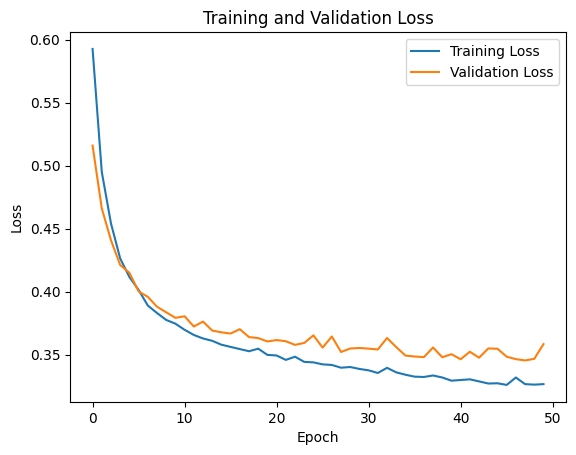

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(valley_losses)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show



In [ ]:
tmp_file = f'{num_epochs}_Iterations_first_{dataset_size}_wikipedia_{wiki2vec}_Convs_{numv_convs}Ben_GCN_model.pth'
torch.save(GCN.state_dict(), tmp_file)

In [ ]:


!gsutil -m cp -r 50_Iterations_first_5000_wikipedia_True_Convs_10Ben_GCN_model.pth gs://dsgt-clef-pan-2024/;

Copying file://50_Iterations_first_5000_wikipedia_True_Convs_10Ben_GCN_model.pth [Content-Type=application/octet-stream]...
|
Operation completed over 1 objects/59.4 MiB.                                     


In [ ]:
tmp_file

'50_Iterations_first_5000_wikipedia_True_Convs_10Ben_GCN_model.pth'